In [1]:
################# Percent of SSC From Different Sed Classes ###############
# The purpose of this script is to look at the perent of total SSC
# on the shelf that is attributed to each sediment clss over time and 
# pull out some general stats to use about this in the paper.
#
# Notes:
# -
#
###########################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import transforms 
from matplotlib import cm, ticker
from glob import glob
import xroms
import cmocean
#import matplotlib.ticker as tick
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

In [3]:
# Set a universal fontsize
fontsize = 25

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 12
matplotlib.rcParams['ytick.major.pad'] = 12

In [4]:
# Load in the grid
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc') # UPDATE PATH


# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)
s_rho_len = int(20)
Nbed_len = 11

# Multiply by masks to make land appear 
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)


# Load in the rho masks 
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH
mask_rho_zeros = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_zeros_ones.nc')
#mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
#mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')

In [5]:
# -------------------------------------------------------------------------------------
# ----------------------- Define a Bunch o Functions ----------------------------
# -------------------------------------------------------------------------------------

# Define a function to pull out the length of time in the model run
# And the time steps
def get_model_time(filenames, num_files):
    """
    This function loops though model output and pulls
    out the entire length of the run, as well as the 
    individual time steps of the run.
    
    Inputs:
    - filenames: path and name of model output
    - num_files: the number of model output files
    
    Outputs:
    - time_len: length of time of model run (integer)
    - time_steps_list: list of time steps of full run (datetimes64)
    - time_lengths: array holding the lenght of time of each output file
    """

    # Create an array to hold the length of time in each output file
    time_lengths = np.empty((num_files))

    # Loop through output to pull out lenth of time
    for k in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[k])

        # Pull out the length of time 
        time_lengths[k] = len(model_output.ocean_time)

    # Now sum over all the lengths to get total time
    time_len = np.sum(time_lengths, axis=0)

    # Convert from float to int
    time_len = int(time_len)

    # Loop back through the output to pull out the time step and save it
    # Make a list to hold the time steps 
    time_steps_list = []
    # Loop through output
    for h in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[h])

        # Get the length of the run
        output_len = len(model_output.ocean_time)

        # Loop through each time step and append it to the list
        for g in range(output_len):
            time_steps_list.append(model_output.ocean_time[g].values)

    # Return this time length and time steps
    return(time_len, time_steps_list, time_lengths)

In [6]:
# Make a function to calculate the depth-integrated SSC and 
# depth-averaged SSC for all sediment class
def calc_depth_int_avg_ssc_allsed(file_names, time_lengths, full_time_len, eta_rho_len, xi_rho_len):
    """
    The purpose of this function is to take a given model output file, load 
    in the output, and caluclate the depth-integrated and depth-averaegd 
    suspended sediment concentrations (SSC) for all sediment classes, and for
    the different sediment classes in the model to get ratios over time.

    Parameters
    ----------
    filename : The name/path of the model output file.

    Returns
    -------
    depth_int_ssc_allsed: Spatail time series of depth-integrated SSC for 
    all sediment classes (kg/m2)
    depth_avg_ssc_allsed: Spatial time series of depth-averaged ssc for a 
    all sediment classes (kg/m3)

    """

    # Make empty arrays to hold the time series
    # All sed
    depth_int_ssc_allsed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_allsed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Pebbles/gravel
    depth_int_ssc_pebs = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_pebs = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Coarse sand
    depth_int_ssc_coarse_sand = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_coarse_sand = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Very fine sand
    depth_int_ssc_fine_sand = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_fine_sand = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Not unique mud class
    depth_int_ssc_not_unique = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_not_unique = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    # Unique mud class
    depth_int_ssc_unique = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_unique = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    
    #
    # Set a time step to track which time step the loop is on
    time_step = 0

    # Get number of files
    num_files = len(file_names)

    # Loop through the model output
    for j in range(num_files):
    #for j in range(1):

        print('j: ', j, flush=True)
        
        # Prep time for saving to arrays
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[j])
        print('start: ', start)
        print('end: ', end)
        
        # Load in the model output
        model_output = xr.open_dataset(file_names[j])
        
        # Pull out the sediment class of interest
        # All sed
        ssc_allsed_tmp = (model_output.sand_01 + model_output.sand_02 + model_output.sand_03 + model_output.mud_01 + model_output.mud_02 + model_output.mud_03 +
                        model_output.mud_04 + model_output.mud_05 + model_output.mud_06 + model_output.mud_07 + model_output.mud_08 + model_output.mud_09 +
                        model_output.mud_10 + model_output.mud_11 + model_output.mud_12 + model_output.mud_13 + model_output.mud_14 + model_output.mud_15 +
                        model_output.mud_16 + model_output.mud_17 + model_output.mud_18 + model_output.mud_19 + model_output.mud_20 + model_output.mud_21 +
                        model_output.mud_22 + model_output.mud_23 + model_output.mud_24)
        # Pebbles/gravel
        ssc_pebs_tmp = model_output.sand_03
        # Coarse sand
        ssc_coarse_sand_tmp = model_output.sand_02
        # Very fine sand
        ssc_fine_sand_tmp = model_output.sand_01
        # Not unique mud class
        ssc_not_unique_tmp = model_output.mud_01
        # Unique mud class
        ssc_unique_tmp = (model_output.mud_02 + model_output.mud_03 +
                        model_output.mud_04 + model_output.mud_05 + model_output.mud_06 + model_output.mud_07 + model_output.mud_08 + model_output.mud_09 +
                        model_output.mud_10 + model_output.mud_11 + model_output.mud_12 + model_output.mud_13 + model_output.mud_14 + model_output.mud_15 +
                        model_output.mud_16 + model_output.mud_17 + model_output.mud_18 + model_output.mud_19 + model_output.mud_20 + model_output.mud_21 +
                        model_output.mud_22 + model_output.mud_23 + model_output.mud_24)
        
        # To collapse to horizontal, multiply each layer by its
        # thickness
        # Calculate the time-varying thickness of the cells
        dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
        
        # Calculate depth-integrated ssc
        # All sed
        depth_int_ssc_allsed[start:end,:,:] = (((ssc_allsed_tmp*dz)).sum(dim='s_rho'))
        # Pebbles/gravel
        depth_int_ssc_pebs[start:end,:,:] = (((ssc_pebs_tmp*dz)).sum(dim='s_rho'))
        # Coarse sand
        depth_int_ssc_coarse_sand[start:end,:,:] = (((ssc_coarse_sand_tmp*dz)).sum(dim='s_rho'))
        # Very fine sand
        depth_int_ssc_fine_sand[start:end,:,:] = (((ssc_fine_sand_tmp*dz)).sum(dim='s_rho'))
        # Not unique mud class
        depth_int_ssc_not_unique[start:end,:,:] = (((ssc_not_unique_tmp*dz)).sum(dim='s_rho'))
        # Unique mud class
        depth_int_ssc_unique[start:end,:,:] = (((ssc_unique_tmp*dz)).sum(dim='s_rho'))
        
        # Divide by bathymetry to get depth-averaged SSC (kg/m3)
        # Do this for all classes but don't return it for now? Or dooooo
        # All sed
        depth_avg_ssc_allsed[start:end,:,:] = depth_int_ssc_allsed[start:end,:,:]/model_output.bath[:,:,:].values
        # Pebbles/gravel
        depth_avg_ssc_pebs[start:end,:,:] = depth_int_ssc_pebs[start:end,:,:]/model_output.bath[:,:,:].values
        # Coarse sand
        depth_avg_ssc_coarse_sand[start:end,:,:] = depth_int_ssc_coarse_sand[start:end,:,:]/model_output.bath[:,:,:].values
        # Very fine sand
        depth_avg_ssc_fine_sand[start:end,:,:] = depth_int_ssc_fine_sand[start:end,:,:]/model_output.bath[:,:,:].values
        # Not unique mud class
        depth_avg_ssc_not_unique[start:end,:,:] = depth_int_ssc_not_unique[start:end,:,:]/model_output.bath[:,:,:].values
        # Unique mud class
        depth_avg_ssc_unique[start:end,:,:] = depth_int_ssc_unique[start:end,:,:]/model_output.bath[:,:,:].values

        
        # Update the base time_step
        time_step = time_step + time_lengths[j]

    
    # Return the depth-integrated and depth-averaged SSC for all variations in classes
    return(depth_int_ssc_allsed, depth_avg_ssc_allsed, depth_int_ssc_pebs, depth_avg_ssc_pebs, depth_int_ssc_coarse_sand, 
    depth_avg_ssc_coarse_sand, depth_int_ssc_fine_sand, depth_avg_ssc_fine_sand, depth_int_ssc_not_unique, depth_avg_ssc_not_unique,
    depth_int_ssc_unique, depth_avg_ssc_unique)

In [ ]:
# Load in/prep model output/file paths/etc

# --- Aggregated ---
# ROMS aggregated output
# dbsed0001
file_names_agg = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_agg2 = sorted(file_names_agg)
# TEMP
#file_names_agg2 = file_names_agg2[:3]

# Check to see if this worked
print(file_names_agg2[0], flush=True)
#print(file_names_agg2[1], flush=True)
#print(file_names_agg2[2], flush=True)
print(file_names_agg2[-1], flush=True)

# Pull out the number of files
num_files_agg = len(file_names_agg2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Aggregated 
full_time_len_agg, time_steps_agg, time_lengths_agg = get_model_time(file_names_agg2, num_files_agg)

# --- Unaggregated ---
# Same but for unagregated
# ROMS aggregated output
# dbsed0001
file_names_unag = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_unag2 = sorted(file_names_unag)

# Check to see if this worked
print(file_names_unag2[0], flush=True)
print(file_names_unag2[1], flush=True)
print(file_names_unag2[2], flush=True)
print(file_names_unag2[-1], flush=True)

# Pull out the number of files
num_files_unag = len(file_names_unag2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Unaggregated 
full_time_len_unag, time_steps_unag, time_lengths_unag = get_model_time(file_names_unag2, num_files_unag)


In [ ]:
# Get a spatial time series of total SSC - 
# both depth-integrated and depth-averaged
# Unique Aggregated run
depth_int_ssc_allsed_agg, depth_avg_ssc_allsed_agg, depth_int_ssc_pebs_agg, depth_avg_ssc_pebs_agg, depth_int_ssc_coarse_sand_agg, depth_avg_ssc_coarse_sand_agg, depth_int_ssc_fine_sand_agg, depth_avg_ssc_fine_sand_agg, depth_int_ssc_notunique_unag, depth_avg_ssc_notunique_unag, depth_int_ssc_unique_agg, depth_avg_ssc_unique_agg = calc_depth_int_avg_ssc_allsed(file_names_agg2, time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

In [ ]:
# Unique Unaggregated run
depth_int_ssc_allsed_unag, depth_avg_ssc_allsed_unag, depth_int_ssc_pebs_unag, depth_avg_ssc_pebs_unag, depth_int_ssc_coarse_sand_unag, depth_avg_ssc_coarse_sand_unag, depth_int_ssc_fine_sand_unag, depth_avg_ssc_fine_sand_unag, depth_int_ssc_notunique_agg, depth_avg_ssc_notunique_agg, depth_int_ssc_unique_unag, depth_avg_ssc_unique_unag = calc_depth_int_avg_ssc_allsed(file_names_unag2, time_lengths_unag, full_time_len_unag, eta_rho_len, xi_rho_len)

In [ ]:
# Once we have these time series, trim them to the time we want
# Aggregated run things 
depth_int_ssc_allsed_agg = depth_int_ssc_allsed_agg[:738,:,:]
depth_avg_ssc_allsed_agg = depth_avg_ssc_allsed_agg[:738,:,:]
depth_int_ssc_pebs_agg = depth_int_ssc_pebs_agg[:738,:,:]
depth_avg_ssc_pebs_agg = depth_avg_ssc_pebs_agg[:738,:,:]
depth_int_ssc_coarse_sand_agg = depth_int_ssc_coarse_sand_agg[:738,:,:]
depth_avg_ssc_coarse_sand_agg = depth_avg_ssc_coarse_sand_agg[:738,:,:]
depth_int_ssc_fine_sand_agg = depth_int_ssc_fine_sand_agg[:738,:,:]
depth_avg_ssc_fine_sand_agg = depth_avg_ssc_fine_sand_agg[:738,:,:]
depth_int_ssc_notuniqe_unag = depth_int_ssc_notuniqe_unag[:738,:,:]
depth_avg_ssc_notuniqe_unag = depth_avg_ssc_notuniqe_unag[:738,:,:]
depth_int_ssc_unique_agg = depth_int_ssc_unique_agg[:738,:,:]
depth_avg_ssc_unique_agg = depth_avg_ssc_unique_agg[:738,:,:]
# Unaggregated run things 
depth_int_ssc_allsed_unag = depth_int_ssc_allsed_unag[:738,:,:]
depth_avg_ssc_allsed_unag = depth_avg_ssc_allsed_unag[:738,:,:]
depth_int_ssc_pebs_unag = depth_int_ssc_pebs_unag[:738,:,:]
depth_avg_ssc_pebs_unag = depth_avg_ssc_pebs_unag[:738,:,:]
depth_int_ssc_coarse_sand_unag = depth_int_ssc_coarse_sand_unag[:738,:,:]
depth_avg_ssc_coarse_sand_unag = depth_avg_ssc_coarse_sand_unag[:738,:,:]
depth_int_ssc_fine_sand_unag = depth_int_ssc_fine_sand_unag[:738,:,:]
depth_avg_ssc_fine_sand_unag = depth_avg_ssc_fine_sand_unag[:738,:,:]
depth_int_ssc_notunique_agg = depth_int_ssc_notunique_agg[:738,:,:]
depth_avg_ssc_notunique_agg = depth_avg_ssc_notunique_agg[:738,:,:]
depth_int_ssc_unique_unag = depth_int_ssc_unique_unag[:738,:,:]
depth_avg_ssc_unique_unag = depth_avg_ssc_unique_unag[:738,:,:]

In [ ]:
# ---------------------------------------------------------------------------
# ---------------------- Save to a NetCDF -----------------------------------
# ---------------------------------------------------------------------------
# Assuming this all works, save the post-processed data to
# a netCDF just in case 

# Set up the data
roms_timeseries_ssc_by_class_aggrun = xr.Dataset(
    data_vars=dict(
        depth_int_ssc_allsed_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_allsed_agg),
        depth_avg_ssc_allsed_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_allsed_agg),
        depth_int_ssc_pebs_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_pebs_agg),
        depth_avg_ssc_pebs_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_pebs_agg),
        depth_int_ssc_coarse_sand_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_coarse_sand_agg),
        depth_avg_ssc_coarse_sand_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_coarse_sand_agg),
        depth_int_ssc_fine_sand_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_fine_sand_agg),
        depth_avg_ssc_fine_sand_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_fine_sand_agg),
        depth_int_ssc_notuniqe_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_notuniqe_unag),
        depth_avg_ssc_notuniqe_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_notuniqe_unag),
        depth_int_ssc_unique_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_unique_agg),
        depth_avg_ssc_unique_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_unique_agg)
        ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg),
        eta_rho=('eta_rho', grid.eta_rho.values),
        xi_rho=('xi_rho', grid.xi_rho.values)
        ),
    attrs=dict(description='Time series of SSC in space broken down by sediment class (and total) for output from unique aggregated mud model run')) 
# Add more metadata?
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_allsed_agg.name='spatial time series of total depth-integrated SSC'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_allsed_agg.name='spatial time series of total depth-averaged SSC'
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_pebs_agg.name='spatial time series of pebble/gravel depth-integrated SSC'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_pebs_agg.name='spatial time series of pebble/gravel depth-averaged SSC'
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_coarse_sand_agg.name='spatial time series of coarse sand depth-integrated SSC'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_coarse_sand_agg.name='spatial time series of coarse sand depth-averaged SSC'
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_fine_sand_agg.name='spatial time series of find sand depth-integrated SSC'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_fine_sand_agg.name='spatial time series of find sand depth-averaged SSC'
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_notunique_unag.name='spatial time series of unaggregated mud depth-integrated SSC (not unique)'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_notunique_unag.name='spatial time series of unaggregated mud depth-averaged SSC (not unique)'
roms_timeseries_ssc_by_class_aggrun.depth_int_ssc_unique_agg.name='spatial time series of aggregated mud depth-integrated SSC (unique)'
roms_timeseries_ssc_by_class_aggrun.depth_avg_ssc_unique_agg.name='spatial time series of aggregated mud depth-averaged SSC (unique)'

# Save to a netcdf
#roms_timeseries_ssc_by_class_aggrun.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_by_class_agg_run.nc')

print('Done saving to NetCDF 1', flush=True)


In [ ]:
# ---------------------------------------------------------------------------
# ---------------------- Save to a NetCDF -----------------------------------
# ---------------------------------------------------------------------------
# Assuming this all works, save the post-processed data to
# a netCDF just in case 

# Set up the data
roms_timeseries_ssc_by_class_unagrun = xr.Dataset(
    data_vars=dict(
        depth_int_ssc_allsed_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_allsed_unag),
        depth_avg_ssc_allsed_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_allsed_unag),
        depth_int_ssc_pebs_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_pebs_unag),
        depth_avg_ssc_pebs_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_pebs_unag),
        depth_int_ssc_coarse_sand_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_coarse_sand_unag),
        depth_avg_ssc_coarse_sand_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_coarse_sand_unag),
        depth_int_ssc_fine_sand_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_fine_sand_unag),
        depth_avg_ssc_fine_sand_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_fine_sand_unag),
        depth_int_ssc_notuniqe_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_notuniqe_agg),
        depth_avg_ssc_notuniqe_agg=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_notuniqe_agg),
        depth_int_ssc_unique_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_int_ssc_unique_unag),
        depth_avg_ssc_unique_unag=(['ocean_time', 'eta_rho', 'xi_rho'], depth_avg_ssc_unique_unag)
        ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg),
        eta_rho=('eta_rho', grid.eta_rho.values),
        xi_rho=('xi_rho', grid.xi_rho.values)
        ),
    attrs=dict(description='Time series of SSC in space broken down by sediment class (and total) for output from unique unaggregated mud model run')) 
# Add more metadata?
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_allsed_unag.name='spatial time series of total depth-integrated SSC'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_allsed_unag.name='spatial time series of total depth-averaged SSC'
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_pebs_unag.name='spatial time series of pebble/gravel depth-integrated SSC'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_pebs_unag.name='spatial time series of pebble/gravel depth-averaged SSC'
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_coarse_sand_unag.name='spatial time series of coarse sand depth-integrated SSC'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_coarse_sand_unag.name='spatial time series of coarse sand depth-averaged SSC'
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_fine_sand_unag.name='spatial time series of find sand depth-integrated SSC'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_fine_sand_unag.name='spatial time series of find sand depth-averaged SSC'
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_notunique_agg.name='spatial time series of aggregated mud depth-integrated SSC (not unique)'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_notunique_agg.name='spatial time series of aggregated mud depth-averaged SSC (not unique)'
roms_timeseries_ssc_by_class_unagrun.depth_int_ssc_unique_unag.name='spatial time series of unaggregated mud depth-integrated SSC (unique)'
roms_timeseries_ssc_by_class_unagrun.depth_avg_ssc_unique_unag.name='spatial time series of unaggregated mud depth-averaged SSC (unique)'

# Save to a netcdf
#roms_timeseries_ssc_by_class_unagrun.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_by_class_unag_run.nc')

print('Done saving to NetCDF 2', flush=True)

In [ ]:
# All of the above cells crash the kernel so 
# process data in different script and save to NetCDFs

In [5]:
# Load in the post-processed data 
ssc_by_class_agg_run = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_by_class_agg_run.nc')
ssc_by_class_unag_run = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_by_class_unag_run.nc')

In [6]:
# Assign the variables to help with code below 

In [7]:
# Then add them up over all space
# # Aggregated run things 
# depth_int_ssc_allsed_agg_sum = ssc_by_class_agg_run.depth_int_ssc_allsed_agg.sum(axis=(1,2))
# depth_avg_ssc_allsed_agg_sum = ssc_by_class_agg_run.depth_avg_ssc_allsed_agg.sum(axis=(1,2))
# depth_int_ssc_pebs_agg_sum = ssc_by_class_agg_run.depth_int_ssc_pebs_agg.sum(axis=(1,2))
# depth_avg_ssc_pebs_agg_sum = ssc_by_class_agg_run.depth_avg_ssc_pebs_agg.sum(axis=(1,2))
# depth_int_ssc_coarse_sand_agg_sum = ssc_by_class_agg_run.depth_int_ssc_coarse_sand_agg.sum(axis=(1,2))
# depth_avg_ssc_coarse_sand_agg_sum = ssc_by_class_agg_run.depth_avg_ssc_coarse_sand_agg.sum(axis=(1,2))
# depth_int_ssc_fine_sand_agg_sum = ssc_by_class_agg_run.depth_int_ssc_fine_sand_agg.sum(axis=(1,2))
# depth_avg_ssc_fine_sand_agg_sum = ssc_by_class_agg_run.depth_avg_ssc_fine_sand_agg.sum(axis=(1,2))
# depth_int_ssc_notunique_unag_sum = ssc_by_class_agg_run.depth_int_ssc_notunique_unag.sum(axis=(1,2))
# depth_avg_ssc_notunique_unag_sum = ssc_by_class_agg_run.depth_avg_ssc_notunique_unag.sum(axis=(1,2))
# depth_int_ssc_unique_agg_sum = ssc_by_class_agg_run.depth_int_ssc_unique_agg.sum(axis=(1,2))
# depth_avg_ssc_unique_agg_sum = ssc_by_class_agg_run.depth_avg_ssc_unique_agg.sum(axis=(1,2))
# Unaggregated run things 
depth_int_ssc_allsed_unag_sum = ssc_by_class_unag_run.depth_int_ssc_allsed_unag.sum(axis=(1,2))
depth_avg_ssc_allsed_unag_sum = ssc_by_class_unag_run.depth_avg_ssc_allsed_unag.sum(axis=(1,2))
depth_int_ssc_pebs_unag_sum = ssc_by_class_unag_run.depth_int_ssc_pebs_unag.sum(axis=(1,2))
depth_avg_ssc_pebs_unag_sum = ssc_by_class_unag_run.depth_avg_ssc_pebs_unag.sum(axis=(1,2))
depth_int_ssc_coarse_sand_unag_sum = ssc_by_class_unag_run.depth_int_ssc_coarse_sand_unag.sum(axis=(1,2))
depth_avg_ssc_coarse_sand_unag_sum = ssc_by_class_unag_run.depth_avg_ssc_coarse_sand_unag.sum(axis=(1,2))
depth_int_ssc_fine_sand_unag_sum = ssc_by_class_unag_run.depth_int_ssc_fine_sand_unag.sum(axis=(1,2))
depth_avg_ssc_fine_sand_unag_sum = ssc_by_class_unag_run.depth_avg_ssc_fine_sand_unag.sum(axis=(1,2))
depth_int_ssc_notunique_agg_sum = ssc_by_class_unag_run.depth_int_ssc_notunique_agg.sum(axis=(1,2))
depth_avg_ssc_notunique_agg_sum = ssc_by_class_unag_run.depth_avg_ssc_notunique_agg.sum(axis=(1,2))
depth_int_ssc_unique_unag_sum = ssc_by_class_unag_run.depth_int_ssc_unique_unag.sum(axis=(1,2))
depth_avg_ssc_unique_unag_sum = ssc_by_class_unag_run.depth_avg_ssc_unique_unag.sum(axis=(1,2))

In [8]:
# Calculate the timeseries of percentages for each class 
# # Aggregated run
# percent_depth_int_ssc_pebs_agg = depth_int_ssc_pebs_agg_sum/depth_int_ssc_allsed_agg_sum
# percent_depth_int_ssc_coarse_sand_agg = depth_int_ssc_coarse_sand_agg_sum/depth_int_ssc_allsed_agg_sum
# percent_depth_int_ssc_fine_sand_agg = depth_int_ssc_fine_sand_agg_sum/depth_int_ssc_allsed_agg_sum
# percent_depth_int_ssc_notunique_unag = depth_int_ssc_notunique_unag_sum/depth_int_ssc_allsed_agg_sum
# percent_depth_int_ssc_unique_agg = depth_int_ssc_unique_agg_sum/depth_int_ssc_allsed_agg_sum
# Unaggregated run
percent_depth_int_ssc_pebs_unag = depth_int_ssc_pebs_unag_sum/depth_int_ssc_allsed_unag_sum
percent_depth_int_ssc_coarse_sand_unag = depth_int_ssc_coarse_sand_unag_sum/depth_int_ssc_allsed_unag_sum
percent_depth_int_ssc_fine_sand_unag = depth_int_ssc_fine_sand_unag_sum/depth_int_ssc_allsed_unag_sum
percent_depth_int_ssc_notunique_agg = depth_int_ssc_notunique_agg_sum/depth_int_ssc_allsed_unag_sum
percent_depth_int_ssc_unique_unag = depth_int_ssc_unique_unag_sum/depth_int_ssc_allsed_unag_sum

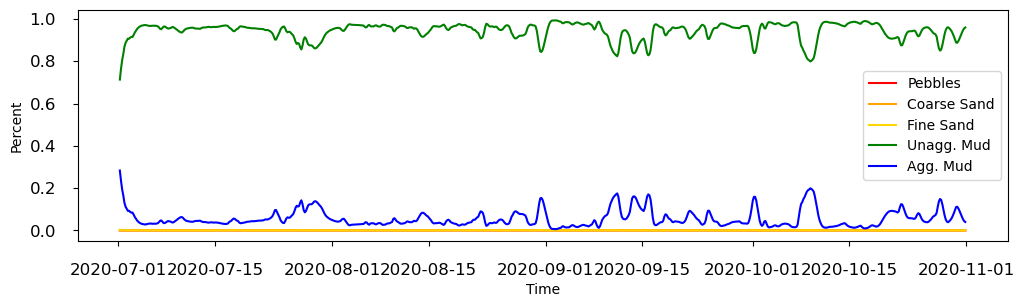

In [17]:
# Then make time series of the percentages
# of different sediment classes on whole shelf 
# Aggregated run output

# Make the figure 
fig, ax = plt.subplots(figsize=(12,3))

# Plot the time series
# Pebbles/gravel
ax.plot(ssc_by_class_agg_run.ocean_time.values, percent_depth_int_ssc_pebs_agg, color='red', label='Pebbles')
# Coarse sand
ax.plot(ssc_by_class_agg_run.ocean_time.values, percent_depth_int_ssc_coarse_sand_agg, color='orange', label='Coarse Sand')
# Very fine sand
ax.plot(ssc_by_class_agg_run.ocean_time.values, percent_depth_int_ssc_fine_sand_agg, color='gold', label='Fine Sand')
# Not unique mud class
ax.plot(ssc_by_class_agg_run.ocean_time.values, percent_depth_int_ssc_notunique_unag, color='green', label='Unagg. Mud')
# Unique mud class
ax.plot(ssc_by_class_agg_run.ocean_time.values, percent_depth_int_ssc_unique_agg, color='blue', label='Agg. Mud')

ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.legend()



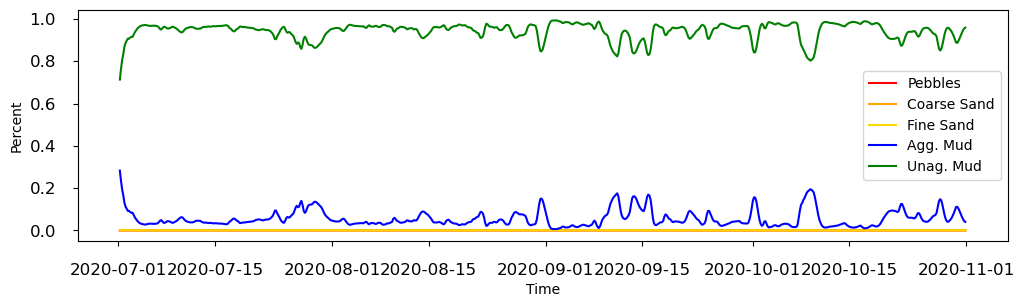

In [12]:
# Same plot but for unaggregated run (should match)
# Make the figure 
fig, ax = plt.subplots(figsize=(12,3))

# Plot the time series
# Pebbles/gravel
ax.plot(ssc_by_class_unag_run.ocean_time.values, percent_depth_int_ssc_pebs_unag, color='red', label='Pebbles')
# Coarse sand
ax.plot(ssc_by_class_unag_run.ocean_time.values, percent_depth_int_ssc_coarse_sand_unag, color='orange', label='Coarse Sand')
# Very fine sand
ax.plot(ssc_by_class_unag_run.ocean_time.values, percent_depth_int_ssc_fine_sand_unag, color='gold', label='Fine Sand')
# Not unique mud class
ax.plot(ssc_by_class_unag_run.ocean_time.values, percent_depth_int_ssc_notunique_agg, color='blue', label='Agg. Mud')
# Unique mud class
ax.plot(ssc_by_class_unag_run.ocean_time.values, percent_depth_int_ssc_unique_unag, color='green', label='Unag. Mud')

ax.set_xlabel('Time')
ax.set_ylabel('Percent')
ax.legend()

In [19]:
# Print a bunch of stats
# Aggregated run
# Pebbles/gravel
mean_percent_pebs_agg = np.mean(percent_depth_int_ssc_pebs_agg)
print('mean percent pebbles/gravel (agg run): ', mean_percent_pebs_agg.values*100)
stddev_percent_pebs_agg = np.std(percent_depth_int_ssc_pebs_agg)
print('std dev percent pebbles/gravel (agg run): ', stddev_percent_pebs_agg.values*100)
# Coarse sand
mean_percent_coarse_sand_agg = np.mean(percent_depth_int_ssc_coarse_sand_agg)
print('mean percent coarse sand (agg run): ', mean_percent_coarse_sand_agg.values*100)
stddev_percent_coarse_sand_agg = np.std(percent_depth_int_ssc_coarse_sand_agg)
print('std dev percent coarse sand (agg run): ', stddev_percent_coarse_sand_agg.values*100)
# Fine sand
mean_percent_fine_sand_agg = np.mean(percent_depth_int_ssc_fine_sand_agg)
print('mean percent fine sand (agg run): ', mean_percent_fine_sand_agg.values*100)
stddev_percent_fine_sand_agg = np.std(percent_depth_int_ssc_fine_sand_agg)
print('std dev percent fine sand (agg run): ', stddev_percent_fine_sand_agg.values*100)
# Unag mud
mean_percent_notunique_unag = np.mean(percent_depth_int_ssc_notunique_unag)
print('mean percent unagg (agg run): ', mean_percent_notunique_unag.values*100)
stddev_percent_notunique_unag = np.std(percent_depth_int_ssc_notunique_unag)
print('std dev percent unagg (agg run): ', stddev_percent_notunique_unag.values*100)
# Agg mud
mean_percent_unique_agg = np.mean(percent_depth_int_ssc_unique_agg)
print('mean percent agg (agg run): ', mean_percent_unique_agg.values*100)
stddev_percent_unique_agg = np.std(percent_depth_int_ssc_unique_agg)
print('std dev percent agg (agg run): ', stddev_percent_unique_agg.values*100)

mean percent pebbles/gravel (agg run):  0.006029844664671817
std dev percent pebbles/gravel (agg run):  0.005149909924630314
mean percent coarse sand (agg run):  0.009570535817130285
std dev percent coarse sand (agg run):  0.00848690522968361
mean percent fine sand (agg run):  0.03375461622913961
std dev percent fine sand (agg run):  0.02687996351413569
mean percent unagg (agg run):  94.3597202829041
std dev percent unagg (agg run):  3.949967761679736
mean percent agg (agg run):  5.590924720384964
std dev percent agg (agg run):  3.9263728655355052


In [11]:
# Same but for unag run 
# Pebbles/gravel
mean_percent_pebs_unag = np.mean(percent_depth_int_ssc_pebs_unag)
print('mean percent pebbles/gravel (unag run): ', mean_percent_pebs_unag.values*100)
stddev_percent_pebs_unag = np.std(percent_depth_int_ssc_pebs_unag)
print('std dev percent pebbles/gravel (unag run): ', stddev_percent_pebs_unag.values*100)
# Coarse sand
mean_percent_coarse_sand_unag = np.mean(percent_depth_int_ssc_coarse_sand_unag)
print('mean percent coarse sand (unag run): ', mean_percent_coarse_sand_unag.values*100)
stddev_percent_coarse_sand_unag = np.std(percent_depth_int_ssc_coarse_sand_unag)
print('std dev percent coarse sand (unag run): ', stddev_percent_coarse_sand_unag.values*100)
# Fine sand
mean_percent_fine_sand_unag = np.mean(percent_depth_int_ssc_fine_sand_unag)
print('mean percent fine sand (unag run): ', mean_percent_fine_sand_unag.values*100)
stddev_percent_fine_sand_unag = np.std(percent_depth_int_ssc_fine_sand_unag)
print('std dev percent fine sand (unag run): ', stddev_percent_fine_sand_unag.values*100)
# Unag mud
mean_percent_notunique_agg = np.mean(percent_depth_int_ssc_notunique_agg)
print('mean percent agg (unag run): ', mean_percent_notunique_agg.values*100)
stddev_percent_notunique_agg = np.std(percent_depth_int_ssc_notunique_agg)
print('std dev percent agg (unag run): ', stddev_percent_notunique_agg.values*100)
# Agg mud
mean_percent_unique_unag = np.mean(percent_depth_int_ssc_unique_unag)
print('mean percent unag (unag run): ', mean_percent_unique_unag.values*100)
stddev_percent_unique_unag = np.std(percent_depth_int_ssc_unique_unag)
print('std dev percent unag (unag run): ', stddev_percent_unique_unag.values*100)

mean percent pebbles/gravel (unag run):  0.005981869897093204
std dev percent pebbles/gravel (unag run):  0.005100295170451982
mean percent coarse sand (unag run):  0.009456128524473723
std dev percent coarse sand (unag run):  0.008372563200966625
mean percent fine sand (unag run):  0.033464307172463584
std dev percent fine sand (unag run):  0.026570916791023132
mean percent agg (unag run):  5.617850095183119
std dev percent agg (unag run):  3.8714248139361294
mean percent unag (unag run):  94.33324759922284
std dev percent unag (unag run):  3.894459546536592
